In [2]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten,Merge
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image as image_processing
import nltk
# from keras.layers import concatenate

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [1]:
!pip install --upgrade tensorflow==1.14
!pip install tensorflow-gpu==1.14
!pip install --upgrade keras==1.2.2
# !pip install tensorflow-gpu==0.12.1

     |████████████████████████████████| 109.3 MB 64 kB/s s eta 0:00:01  |██                              | 6.6 MB 2.8 MB/s eta 0:00:38     |███▌                            | 11.8 MB 2.8 MB/s eta 0:00:36
     |████████████████████████████████| 3.1 MB 37.3 MB/s eta 0:00:01
     |████████████████████████████████| 488 kB 42.8 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 5.9 MB/s  eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
ERROR: pip's dependency resolver does not c

In [ ]:
import sys
sys.version

In [3]:
import tensorflow as tf
tf.placeholder

<function tensorflow.python.ops.array_ops.placeholder(dtype, shape=None, name=None)>

In [4]:
import keras
keras.__version__

'1.2.2'

In [5]:
token = '../input/flickr8k/captions.txt'

In [6]:
captions = open(token, 'r').read().strip().split('\n')

In [7]:
captions = captions[1:] # remove first caption as it's only the word image caption

In [8]:
print(captions[35])

1012212859_01547e3f17.jpg,"A dog shakes its head near the shore , a red ball next to it ."


## Creating a dictionary containing all the captions of the images

In [9]:
d = {} # list of images
for index,row in enumerate(captions):
    row = row.split(",")
    row_image = row[0]
    caption = "".join(row[1:])
    if row_image in d:
        d[row_image].append(caption)
    else:
        d[row_image] = [caption]

In [10]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
images = '../input/flickr8k/Images'

In [12]:
# Contains all the images
img = []
for image in d:
    img.append("../input/flickr8k/Images/"+image)

In [13]:
img[:5]

['../input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '../input/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '../input/flickr8k/Images/1002674143_1b742ab4b8.jpg',
 '../input/flickr8k/Images/1003163366_44323f5815.jpg',
 '../input/flickr8k/Images/1007129816_e794419615.jpg']

In [14]:
train_img = img[:6000]
val_img = img[6000:7000]
test_img = img[7000:]

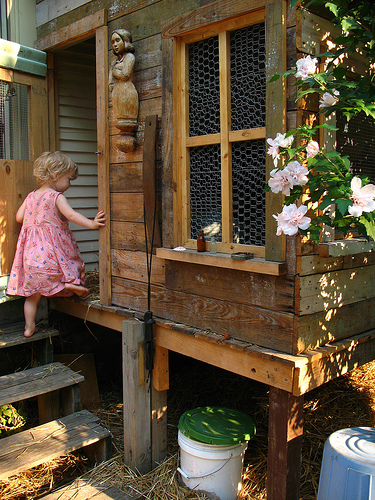

In [15]:
Image.open(train_img[0])

In [16]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [17]:
def preprocess(image_path):
    img = image_processing.load_img(image_path, target_size=(299, 299))
    x = image_processing.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

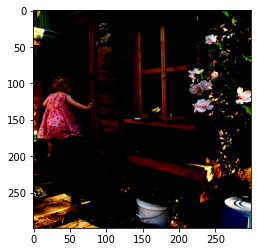

In [18]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [19]:
model = InceptionV3(weights='imagenet')

In [20]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [21]:
tryi = model_new.predict(preprocess(train_img[0]))

In [22]:
tryi.shape

(1, 2048)

In [23]:
tryi

array([[ 0.13695386,  0.1644569 ,  0.14198552, ..., -0.06527665,
        -0.10643787, -0.2586674 ]], dtype=float32)

# Encoding

In [24]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [25]:
encode(train_img[0])

array([ 0.13695386,  0.1644569 ,  0.14198552, ..., -0.06527665,
       -0.10643787, -0.2586674 ], dtype=float32)

In [26]:
train_img[0]

'../input/flickr8k/Images/1000268201_693b08cb0e.jpg'

In [ ]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img] = encode(img)

In [ ]:
len(encoding_train)

In [ ]:
encoding_train["../input/flickr8k/Images/1000268201_693b08cb0e.jpg"]

In [ ]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [ ]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [ ]:
encoding_train["../input/flickr8k/Images/1000268201_693b08cb0e.jpg"]

# Encoding Test data

In [28]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img] = encode(img)

100%|██████████| 1091/1091 [03:58<00:00,  4.58it/s]


In [29]:
encoding_test[test_img[0]]

array([-0.2645367 , -0.09113786,  0.11458602, ..., -0.08601699,
       -0.18390392, -0.01631956], dtype=float32)

In [30]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [31]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [32]:
encoding_test[test_img[0]]

array([-0.2645367 , -0.09113786,  0.11458602, ..., -0.08601699,
       -0.18390392, -0.01631956], dtype=float32)

In [33]:
images_path = '../input/flickr8k/Images/'
len_images_path = len(images_path)

In [34]:
train_d = {}
for i in train_img:
    train_d[i] = d[i[len_images_path:]]

len(train_d)

6000

In [35]:
val_d = {}
for i in val_img:
    val_d[i] = d[i[len_images_path:]]

len(val_d)

1000

In [36]:
test_d = {}
for i in test_img:
    test_d[i] = d[i[len_images_path:]]

len(test_d)

1091

# Calculating the unique words in the vocabulary.

In [37]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [38]:
caps[:10]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>',
 '<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> Two dogs of different breeds looking at each other on the road . <end>',
 '<start> Two dogs on pavement moving toward each other . <end>']

In [39]:
words = [i.split() for i in caps]

In [40]:
unique = pickle.load(open('../input/unique-p/unique.p', 'rb'))

In [41]:
word2idx = {val:index for index, val in enumerate(unique)}

In [42]:
word2idx['<start>']

5553

In [43]:
idx2word = {index:val for index, val in enumerate(unique)}

In [44]:
idx2word[5553]

'<start>'

Calculating the maximum length among all the captions

In [45]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

39

# Adding start  and end  to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [46]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [47]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [48]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [49]:
len(df)

30000

In [50]:
c = [i for i in df['captions']]
len(c)

30000

In [51]:
imgs = [i for i in df['image_id']]

In [52]:
a = c[-1]
a, imgs[-1]

('<start> Trainer runs her dog through training course with green pipe <end>',
 '/3508882611_3947c0dbf5.jpg')

In [53]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 5553
Trainer => 5109
runs => 5544
her => 7258
dog => 173
through => 6525
training => 3055
course => 1725
with => 4350
green => 2810
pipe => 6785
<end> => 5232


In [54]:
caps[:10]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>',
 '<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> Two dogs of different breeds looking at each other on the road . <end>',
 '<start> Two dogs on pavement moving toward each other . <end>']

In [55]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [56]:
samples_per_epoch

380640

## Generator 




In [ ]:
encoding_train['../input/flickr8k/Images/1000268201_693b08cb0e.jpg']

In [ ]:
len(encoding_train['../input/flickr8k/Images/1000268201_693b08cb0e.jpg'])

In [60]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train["../input/flickr8k/Images"+imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## the model

Input dimension is 4096 since we will feed it the encoded version of the image.

In [61]:
embedding_size = 300
vocab_size = 8256
max_len = 40


In [62]:


image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [63]:
caption_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=300, input_length=40),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

In [64]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           614700                                       
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 40, 300)       0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 40, 300)       2476800                                      
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 40, 256)       570368                                       
___________________________________________________________________________________________

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=30, 
                          verbose=2)

In [ ]:
final_model.save_weights('time_inceptionV3_7_loss_3.2604.h5')

In [65]:
final_model.load_weights('../input/image-caption-saved-weights/time_inceptionV3_1.5987_loss.h5')

Merging the models and creating a softmax classifier

In [66]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [69]:
import requests, uuid, json
subscription_key = "your key goes here"
endpoint = "https://api.cognitive.microsofttranslator.com"


# Add your subscription key and endpoint


# Add your location, also known as region. The default is global.
# This is required if using a Cognitive Services resource.
location = "francecentral"

path = "/translate"
constructed_url = endpoint + path

params = {"api-version": "3.0", "from": "en", "to": ["ar"]}
constructed_url = endpoint + path

headers = {
    "Ocp-Apim-Subscription-Key": subscription_key,
    "Ocp-Apim-Subscription-Region": location,
    "Content-type": "application/json",
    "X-ClientTraceId": str(uuid.uuid4()),
}


def translate(text):

    # You can pass more than one object in body.
    body = [{"text": text}]

    request = requests.post(constructed_url, params=params, headers=headers, json=body)
    response = request.json()
    # response = json.dumps(response, sort_keys=True, indent=4, separators=(",", ": "))
    return response[0]["translations"][0]["text"]

A group of people are standing together outside .
مجموعة من الناس يقفون معا في الخارج.


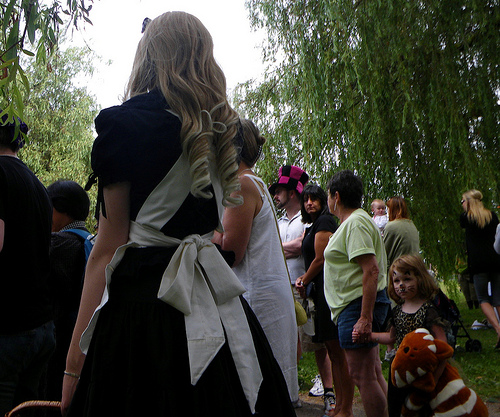

In [70]:
try_image = test_img[1]
predcted_output = predict_captions(try_image)
print(predcted_output)
print(translate(predcted_output))

Image.open(try_image)

A brown and white dog is walking through a grassy field .
بني وأبيض يسير عبر حقل عشبي.


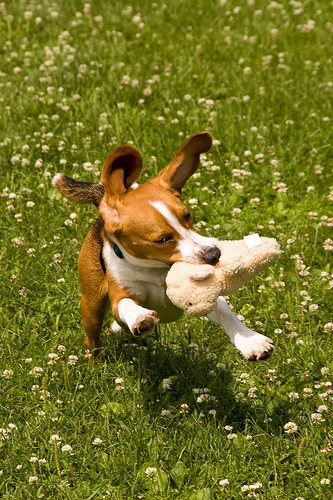

In [71]:
try_image = test_img[2]
predcted_output = predict_captions(try_image)
print(predcted_output)
print(translate(predcted_output))

Image.open(try_image)

A male hiker carries his gear up the street .
متجول ذكر يحمل معداته في الشارع.


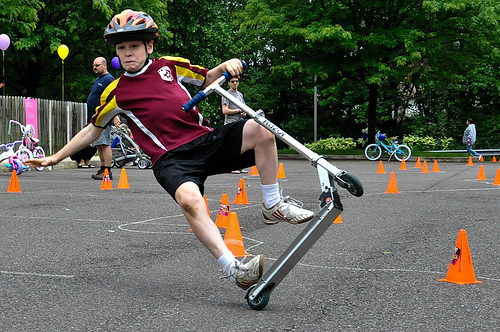

In [72]:
try_image = test_img[4]
predcted_output = predict_captions(try_image)
print(predcted_output)
print(translate(predcted_output))

Image.open(try_image)

A woman wearing a scarf on her head sits next to a young woman .
امرأة ترتدي وشاحا على رأسها تجلس بجانب شابة.


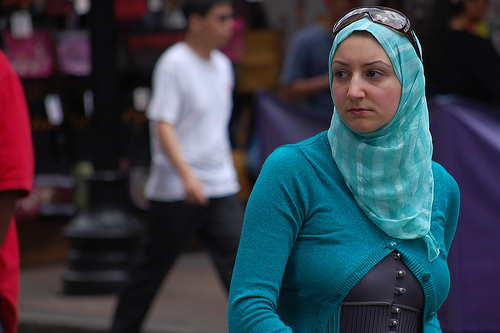

In [73]:
try_image = test_img[5]
predcted_output = predict_captions(try_image)
print(predcted_output)
print(translate(predcted_output))

Image.open(try_image)

A black dog is standing in the snow .
أسود يقف في الثلج.


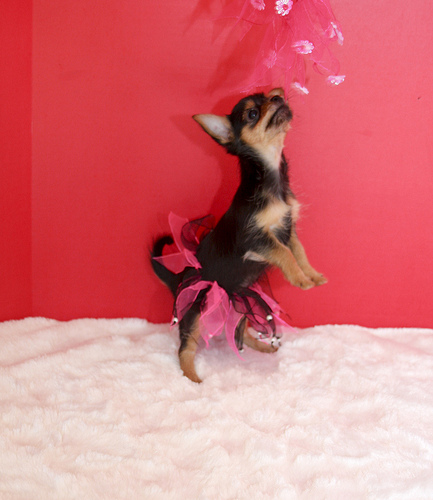

In [74]:
try_image = test_img[8]
predcted_output = predict_captions(try_image)
print(predcted_output)
print(translate(predcted_output))

Image.open(try_image)

A woman sits on a sidewalk with a green rope .
امرأة تجلس على الرصيف بحبل أخضر.


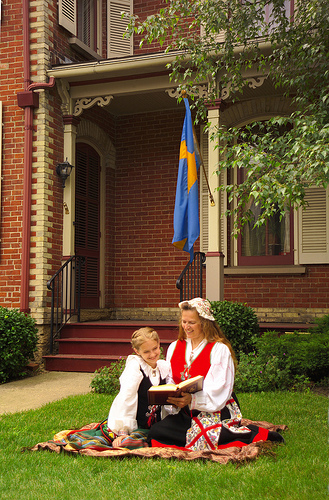

In [75]:
try_image = test_img[12]
predcted_output = predict_captions(try_image)
print(predcted_output)
print(translate(predcted_output))

Image.open(try_image)

A man wearing a white shirt is standing in a stadium with a white object in his hand .
رجل يرتدي قميصا أبيض يقف في ملعب مع كائن أبيض في يده .


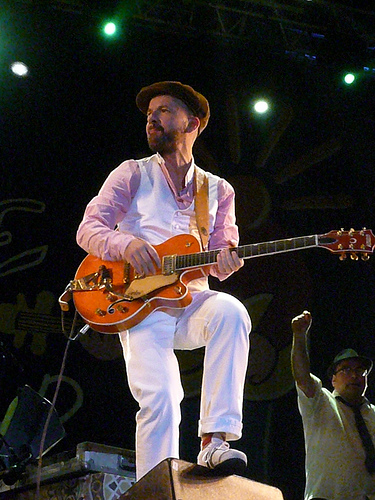

In [76]:
try_image = test_img[15]
predcted_output = predict_captions(try_image)
print(predcted_output)
print(translate(predcted_output))

Image.open(try_image)

A rugby player in red gets ready to tackle the player .
لاعب الركبي في الأحمر يحصل على استعداد لمعالجة لاعب .


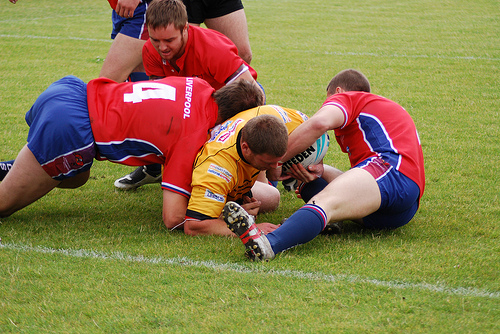

In [77]:
try_image = test_img[0]
predcted_output = predict_captions(try_image)
print(predcted_output)
print(translate(predcted_output))

Image.open(try_image)

A woman and three children walk on the beach in a line .
امرأة وثلاثة أطفال يسيرون على الشاطئ في خط .


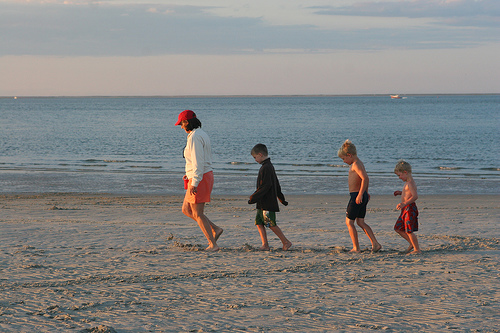

In [80]:
try_image = test_img[862]
predcted_output = predict_captions(try_image)
print(predcted_output)
print(translate(predcted_output))

Image.open(try_image)